In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 8
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
CHANNELS= 3
EPOCHS=50

In [3]:
# Directory with the images
data_dir = "Binary_Class_Eras_Tour"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 201 files belonging to 2 classes.


In [4]:
# Name of the classes
class_names = dataset.class_names
print(class_names)

['1_Fearless', '2_Speak_Now']


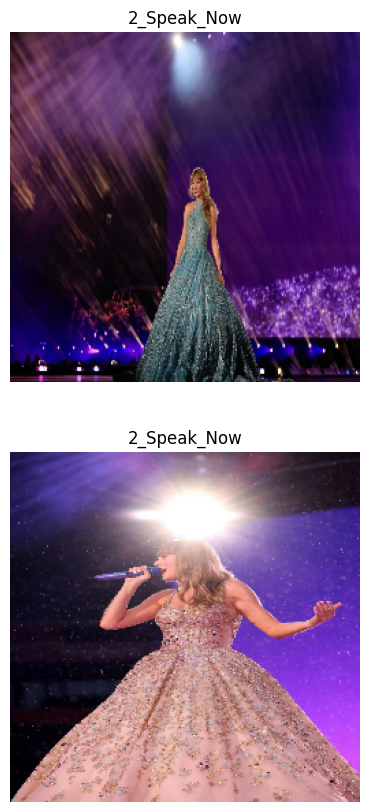

In [5]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(2):
    ax = plt.subplot(2, 1, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Display the shape of batched train samples
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


In [7]:
def subset_creation(dataset, train_split=0.7, test_split=0.1, val_split=0.2, shuffle=True, shuffle_size=100):

    assert (train_split + test_split + val_split) == 1

    size_dataset = len(dataset)

    if shuffle:
            dataset = dataset.shuffle(shuffle_size, seed=123)
    
    train_size = int(size_dataset * train_split)
    test_size = int(size_dataset * test_split)
    val_size = int(size_dataset * val_split)


    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(test_size).take(val_size)

    return train_dataset, val_dataset, test_dataset

In [8]:
train_ds, val_ds, test_ds = subset_creation(dataset)

In [9]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 18
        - val split: 5
        - test split: 2
    ----------------------------------
    


In [10]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Normalize and rescale the images
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [12]:
# Proof that the images are rescaled
normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(0.2),
  #tf.keras.layers.RandomCrop(height=1, width=1),
  #tf.keras.layers.RandomZoom(0.2),
  #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  #tf.keras.layers.RandomBrightness(factor=0.2)
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CHANNELS, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Ronan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 254, 254, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 125, 125, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 62, 62, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 60, 60, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 30, 30, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (8, 28, 28, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (8, 14, 14, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (8, 12, 12, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (8, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (8, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (8, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
filepath="saved_models/best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [checkpoint, es]

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=callbacks_list
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3700 - loss: 0.9979
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to saved_models/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.3751 - loss: 0.9908 - val_accuracy: 0.5455 - val_loss: 0.8243
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4005 - loss: 0.8618
Epoch 2: val_accuracy did not improve from 0.54545
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4025 - loss: 0.8584 - val_accuracy: 0.5152 - val_loss: 0.7244
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4929 - loss: 0.7282
Epoch 3: val_accuracy did not improve from 0.54545
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4946 - loss: 0.7281 - val_accuracy: 0.4545 - val_loss: 0.6976
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4518 - loss: 0.7048
Epoch 4: val_accuracy improved from 0.54545 to 0.57576, saving model to saved_models/best_model.keras
18/18 ━━

In [26]:
filepath = "saved_models\\best_model.keras"
best_model = tf.keras.models.load_model(filepath)

In [28]:
scores = best_model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9583 - loss: 0.1441 


In [29]:
print("Accuracy: %.2f%%"% (scores[1]*100))

Accuracy: 93.75%


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

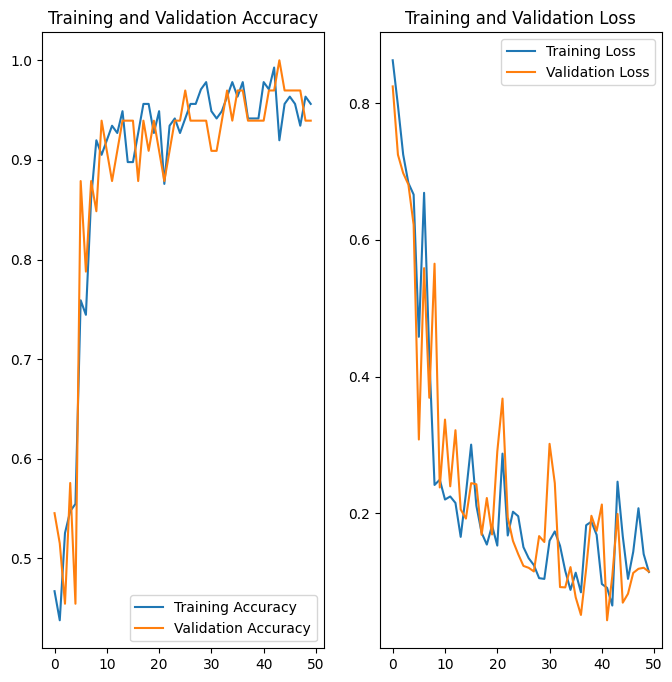

In [56]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 2_Speak_Now
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
predicted label: 2_Speak_Now


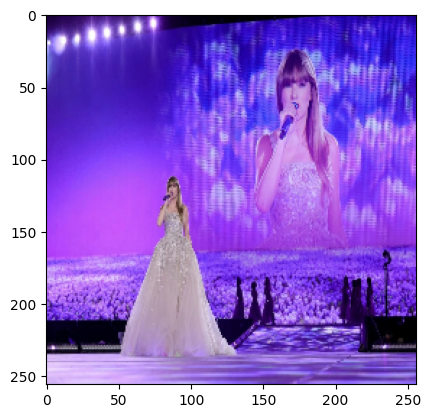

In [31]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = best_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = best_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


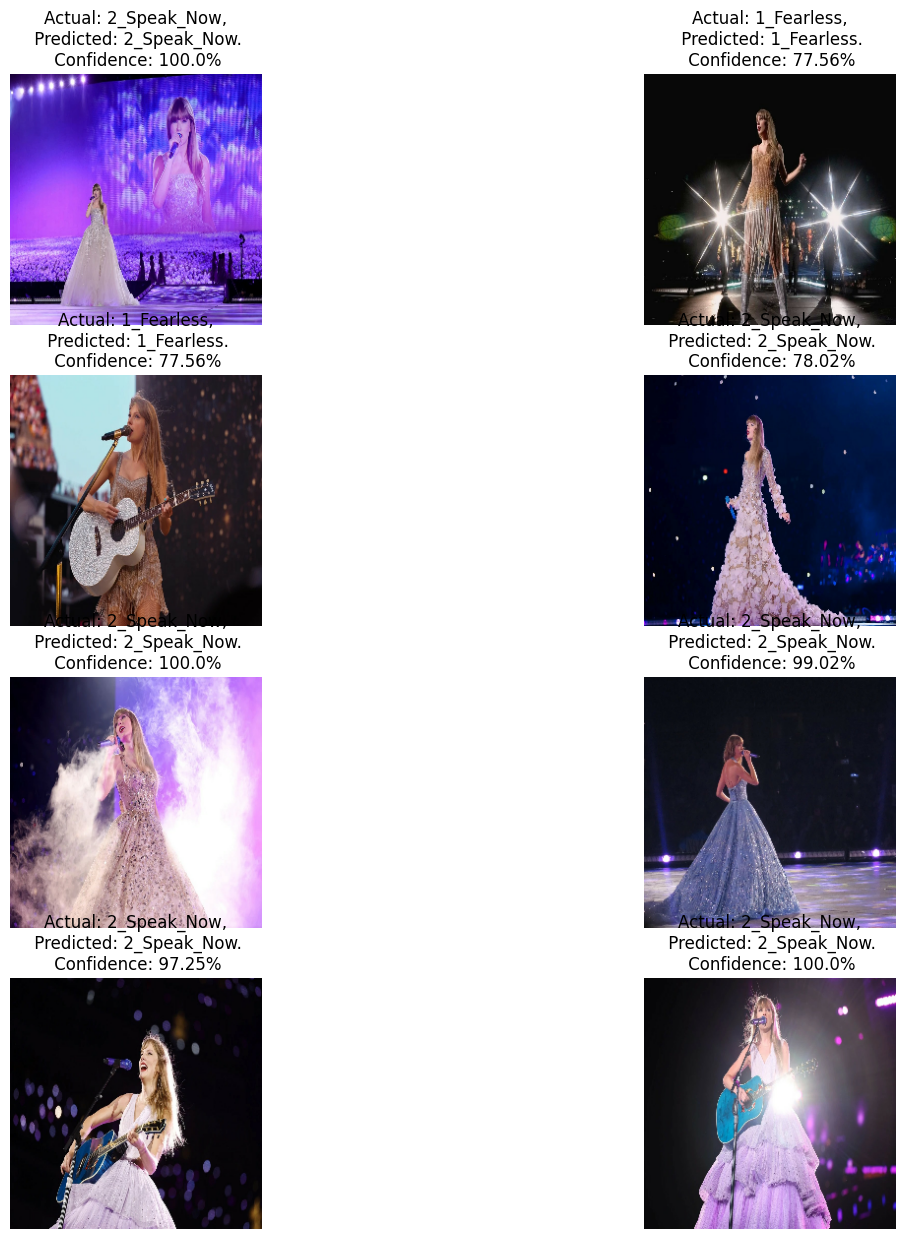

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")